# Kriging with Synthetic Oil Wells

### Loading Tools and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from itertools import product
from skgstat import Variogram, OrdinaryKriging
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pprint
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
n_rows = 750
np.random.seed(42)

surface_longitude_corr = np.random.uniform(-100, -90, n_rows)
surface_latitude_corr = np.random.uniform(30, 40, n_rows)
gas_prod_corr = np.random.normal(loc=1000, scale=50, size=n_rows) + 50 * surface_longitude_corr
oil_prod_corr = np.random.normal(loc=500, scale=25, size=n_rows) + 25 * surface_latitude_corr

surface_longitude_non_corr = np.random.uniform(-100, -90, n_rows)
surface_latitude_non_corr = np.random.uniform(30, 40, n_rows)
gas_prod_non_corr = np.random.normal(loc=1000, scale=300, size=n_rows)
oil_prod_non_corr = np.random.normal(loc=500, scale=150, size=n_rows)

fields = {
    'API_WellNo': np.random.randint(10000000000000, 99999999999999, n_rows),
    'Cnty': np.random.choice(['CountyA', 'CountyB', 'CountyC'], n_rows),
    'Hole_x': np.random.randint(10000, 99999, n_rows),
    'SideTrck_x': np.random.randint(0, 10, n_rows),
    'Completion_x': np.random.randint(0, 10, n_rows),
    'Well_Name': np.random.choice(['WellA', 'WellB', 'WellC'], n_rows),
    'Company_name': np.random.choice(['CompanyX', 'CompanyY', 'CompanyZ'], n_rows),
    'Operator_number': np.random.randint(1000, 9999, n_rows),
    'Well_Type': np.random.choice(['Oil', 'Gas'], n_rows),
    'Map_Symbol': np.random.choice(['Symbol1', 'Symbol2'], n_rows),
    'Well_Status': np.random.choice(['Active', 'Inactive'], n_rows),
    'Date_Status': pd.to_datetime(np.random.choice(pd.date_range('2000-01-01', '2020-01-01'), n_rows)),
    'Date_Permit_Application': pd.to_datetime(np.random.choice(pd.date_range('1990-01-01', '2010-01-01'), n_rows)),
    'Permit_Issued': pd.to_datetime(np.random.choice(pd.date_range('1990-01-01', '2010-01-01'), n_rows)),
    'Date_Spudded': pd.to_datetime(np.random.choice(pd.date_range('1995-01-01', '2015-01-01'), n_rows)),
    'Date_Total_Depth': pd.to_datetime(np.random.choice(pd.date_range('1995-01-01', '2015-01-01'), n_rows)),
    'Date_Well_Completed': pd.to_datetime(np.random.choice(pd.date_range('1995-01-01', '2015-01-01'), n_rows)),
    'Date_well_plugged': pd.to_datetime(np.random.choice(pd.date_range('2000-01-01', '2020-01-01'), n_rows)),
    'Date_well_confidential': pd.to_datetime(np.random.choice(pd.date_range('2000-01-01', '2025-01-01'), n_rows)),
    'confid': np.random.randint(0, 2, n_rows),
    'town_x': np.random.choice(['TownA', 'TownB', 'TownC'], n_rows),
    'quad': np.random.choice(['QuadA', 'QuadB', 'QuadC'], n_rows),
    'quadsec': np.random.choice(['SecA', 'SecB', 'SecC'], n_rows),
    'Producing_name': np.random.choice(['Field1', 'Field2', 'Field3'], n_rows),
    'Producing_formation': np.random.choice(['Formation1', 'Formation2'], n_rows),
    'Financial_security': np.random.choice(['Yes', 'No'], n_rows),
    'Slant': np.random.choice(['Vertical', 'Horizontal', 'Directional'], n_rows),
    'County_x': np.random.choice(['CountyX', 'CountyY', 'CountyZ'], n_rows),
    'Region': np.random.choice(['Region1', 'Region2', 'Region3'], n_rows),
    'State_lease': np.random.choice(['Lease1', 'Lease2', 'Lease3'], n_rows),
    'Proposed_depth': np.random.randint(1000, 5000, n_rows),
    'Surface_location': np.random.choice(['Surface1', 'Surface2'], n_rows),
    'Bottom_hole_location': np.random.choice(['BottomHole1', 'BottomHole2'], n_rows),
    'Bottom_hole_longitude': surface_longitude_corr,
    'Bottom_hole_latitude': surface_latitude_corr,
    'True_vertical_depth': np.random.randint(500, 3000, n_rows),
    'Measured_depth': np.random.randint(1000, 6000, n_rows),
    'Kickoff': np.random.randint(100, 1000, n_rows),
    'DrilledDepth': np.random.randint(500, 5000, n_rows),
    'Elevation': np.random.randint(100, 1000, n_rows),
    'Original_well_type': np.random.choice(['Type1', 'Type2'], n_rows),
    'Permit_Fee': np.random.randint(1000, 10000, n_rows),
    'Objective_formation': np.random.choice(['Formation1', 'Formation2'], n_rows),
    'Depth_Fee': np.random.randint(500, 5000, n_rows),
    'Spacing': np.random.choice(['Spacing1', 'Spacing2'], n_rows),
    'Spacing_Acres': np.random.randint(10, 1000, n_rows),
    'Integration': np.random.choice(['Integration1', 'Integration2'], n_rows),
    'Dt_Hearing': pd.to_datetime(np.random.choice(pd.date_range('2000-01-01', '2020-01-01'), n_rows)),
    'Dt_Mod': pd.to_datetime(np.random.choice(pd.date_range('2000-01-01', '2020-01-01'), n_rows)),
    'LINK': ['http://example.com'] * n_rows,
    'Location_Verified': np.random.choice(['Yes', 'No'], n_rows),
    'GeneralWellType': np.random.choice(['TypeA', 'TypeB'], n_rows),
    'GeneralWellStatus': np.random.choice(['StatusA', 'StatusB'], n_rows),
    'County_y': np.random.choice(['CountyX', 'CountyY'], n_rows),
    'CoName': np.random.choice(['CompanyX', 'CompanyY'], n_rows),
    'Hole_y': np.random.randint(10000, 99999, n_rows),
    'SideTrck_y': np.random.randint(0, 10, n_rows),
    'Completion_y': np.random.randint(0, 10, n_rows),
    'Well_Typ': np.random.choice(['Oil', 'Gas'], n_rows),
    'Field': np.random.choice(['Field1', 'Field2'], n_rows),
    'Wl_Status': np.random.choice(['Active', 'Inactive'], n_rows),
    'Well_Nm': np.random.choice(['WellA', 'WellB'], n_rows),
    'town_y': np.random.choice(['TownA', 'TownB'], n_rows),
    'Prod Form': np.random.choice(['Formation1', 'Formation2'], n_rows),
    'MonthProd': np.random.randint(1, 12, n_rows),
    'GasProd': gas_prod_corr,
    'WaterProd': np.random.randint(0, 1000, n_rows),
    'OilProd': oil_prod_corr,
    'Year': np.random.choice([2000, 2005, 2010, 2015, 2020], n_rows) }

fields['GasProd'] = gas_prod_corr
fields['OilProd'] = oil_prod_corr
fields['Surface_Longitude'] = surface_longitude_corr
fields['Surface_Latitude'] = surface_latitude_corr
df_corr = pd.DataFrame(fields)

fields['GasProd'] = gas_prod_non_corr
fields['OilProd'] = oil_prod_non_corr
fields['Surface_Longitude'] = surface_longitude_non_corr
fields['Surface_Latitude'] = surface_latitude_non_corr
df_nocorr = pd.DataFrame(fields)

In [3]:
print(f'df_corr.shape:  {df_corr.shape}')
print(f'df_nocorr.shape: {df_nocorr.shape}')

df_corr.shape:  (750, 71)
df_nocorr.shape: (750, 71)


In [4]:
df_corr = df_corr[[
    # 'Hole_x', 'SideTrck_x', 'Completion_x', 'Well_Name', 'Company_name', 
    # 'Operator_number', 'Map_Symbol', 'confid', 'Financial_security', 'Slant', 
    # 'Date_Status', 'Date_Permit_Application', 'Permit_Issued', 'Date_Spudded',
    # 'Date_Total_Depth', 'Date_Well_Completed', 'Date_well_plugged', 'Completion_y',
    # 'Date_well_confidential', 'Original_well_type', 'Permit_Fee', 'Well_Typ',
    # 'Objective_formation', 'Depth_Fee', 'Spacing', 'Spacing_Acres', 'Integration',
    # 'Dt_Hearing', 'Dt_Mod', 'LINK', 'Location_Verified', 'GeneralWellType',
    # 'GeneralWellStatus', 'County_y', 'CoName', 'Hole_y', 'SideTrck_y',
    'API_WellNo', 'Cnty', 'Well_Type', 'Well_Status', 'Producing_name',
    'Producing_formation', 'Proposed_depth', 'Surface_Longitude', 'Surface_Latitude',
    'Bottom_hole_longitude', 'Bottom_hole_latitude', 'True_vertical_depth', 
    'Measured_depth', 'GasProd', 'OilProd', 'WaterProd', 'Year' ]].copy()

df_nocorr = df_nocorr[[
    # 'Hole_x', 'SideTrck_x', 'Completion_x', 'Well_Name', 'Company_name', 
    # 'Operator_number', 'Map_Symbol', 'confid', 'Financial_security', 'Slant', 
    # 'Date_Status', 'Date_Permit_Application', 'Permit_Issued', 'Date_Spudded',
    # 'Date_Total_Depth', 'Date_Well_Completed', 'Date_well_plugged', 'Completion_y',
    # 'Date_well_confidential', 'Original_well_type', 'Permit_Fee', 'Well_Typ',
    # 'Objective_formation', 'Depth_Fee', 'Spacing', 'Spacing_Acres', 'Integration',
    # 'Dt_Hearing', 'Dt_Mod', 'LINK', 'Location_Verified', 'GeneralWellType',
    # 'GeneralWellStatus', 'County_y', 'CoName', 'Hole_y', 'SideTrck_y',
    'API_WellNo', 'Cnty', 'Well_Type', 'Well_Status', 'Producing_name',
    'Producing_formation', 'Proposed_depth', 'Surface_Longitude', 'Surface_Latitude',
    'Bottom_hole_longitude', 'Bottom_hole_latitude', 'True_vertical_depth', 
    'Measured_depth', 'GasProd', 'OilProd', 'WaterProd', 'Year' ]].copy()

In [5]:
print(f'df_corr.shape:  {df_corr.shape}')
print(f'df_nocorr.shape: {df_nocorr.shape}')

df_corr.shape:  (750, 17)
df_nocorr.shape: (750, 17)


## Spatially Correlated Data

In [6]:
df = df_corr.copy()
print(df.shape)
df.head()

(750, 17)


,API_WellNo,Cnty,Well_Type,Well_Status,Producing_name,Producing_formation,Proposed_depth,Surface_Longitude,Surface_Latitude,Bottom_hole_longitude,Bottom_hole_latitude,True_vertical_depth,Measured_depth,GasProd,OilProd,WaterProd,Year
0,24012181361672,CountyC,Gas,Active,Field2,Formation2,4352,-96.25,31.17,-96.25,31.17,2417,3280,"-3,937.70","1,322.54",304,2005
1,89418511661948,CountyA,Gas,Active,Field3,Formation2,4478,-90.49,39.40,-90.49,39.40,2681,4749,"-3,410.10","1,540.74",27,2010
2,30087839072036,CountyA,Gas,Active,Field1,Formation1,4927,-92.68,36.28,-92.68,36.28,1113,3538,"-3,703.48","1,422.88",287,2010
3,28316077141053,CountyA,Oil,Inactive,Field1,Formation2,4684,-94.01,33.35,-94.01,33.35,1927,2016,"-3,782.94","1,346.25",354,2005
4,59875564545465,CountyB,Gas,Inactive,Field3,Formation1,3841,-98.44,31.39,-98.44,31.39,2016,1443,"-3,870.86","1,239.79",966,2010


### Flattened Overview Plot `(Lat, Long, Hue=GasProd)`

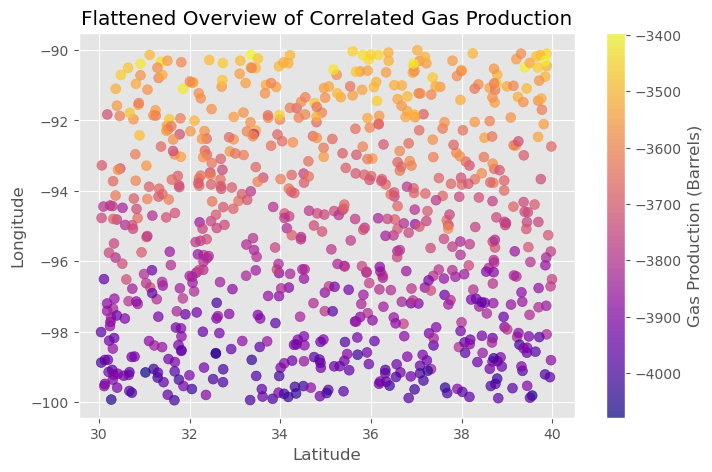

In [7]:
fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(np.array(df['Surface_Latitude']), np.array(df['Surface_Longitude']), 
                       s=50, c=np.array(df['GasProd']).flatten(), cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Gas Production (Barrels)')
plt.title('Flattened Overview of Correlated Gas Production')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()
plt.close()

### Gas Production - Variogram

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 188.91875879761298,
 'normalized_sill': 7672382005.818387,
 'normalized_nugget': 0,
 'effective_range': 13.74477205331587,
 'sill': 68615.84084788509,
 'nugget': 0,
 'params': {'estimator': 'matheron',
            'model': 'spherical',
            'dist_func': 'euclidean',
            'bin_func': 'even',
            'normalize': False,
            'fit_method': 'trf',
            'fit_sigma': None,
            'use_nugget': False,
            'maxlag': None,
            'n_lags': 10,
            'verbose': False},
 'kwargs': {}}


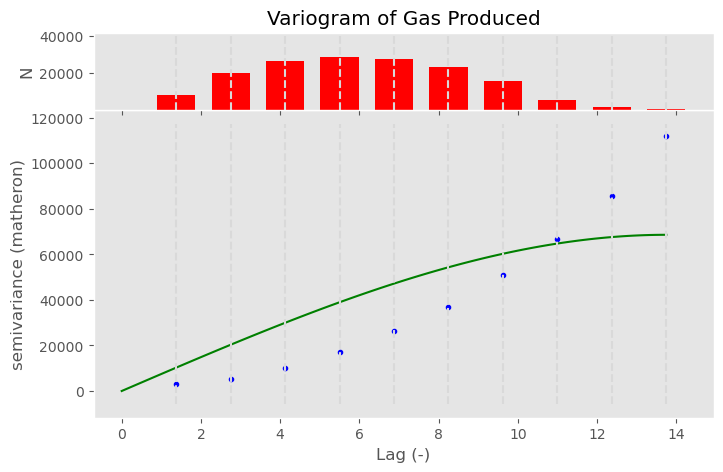

In [8]:
train, test = train_test_split(df, test_size=0.25, random_state=42)
xy_gasprod_train = np.array(train[['Surface_Latitude','Surface_Longitude']].values)
v_gasprod_train = np.array(train['GasProd'].values)

gas_variogram = Variogram(coordinates=xy_gasprod_train, values=v_gasprod_train)
pprint.pp(gas_variogram.describe())

gas_variogram.plot()
plt.title('Variogram of Gas Produced')
plt.show()
plt.close()

### Gas Production - Kriging

In [9]:
ok = OrdinaryKriging(gas_variogram)
xy_gasprod_test = np.array(test[['Surface_Latitude', 'Surface_Longitude']].values)
v_gasprod_test = np.array(test['GasProd'].values)

pred = ok.transform(xy_gasprod_test)
actual = v_gasprod_test
test['pred_GasProd'] = pred
s2 = ok.sigma

rmse = np.sqrt(mean_squared_error(actual, pred))
print("RMSE:", rmse)
mae = mean_absolute_error(actual, pred)
print("MAE:", mae)
r2 = r2_score(actual, pred)
print("R2:", r2)

RMSE: 60.564075976072075
MAE: 49.80354849598328
R2: 0.8622787685033206


### Gas Production - Kriging - Plots

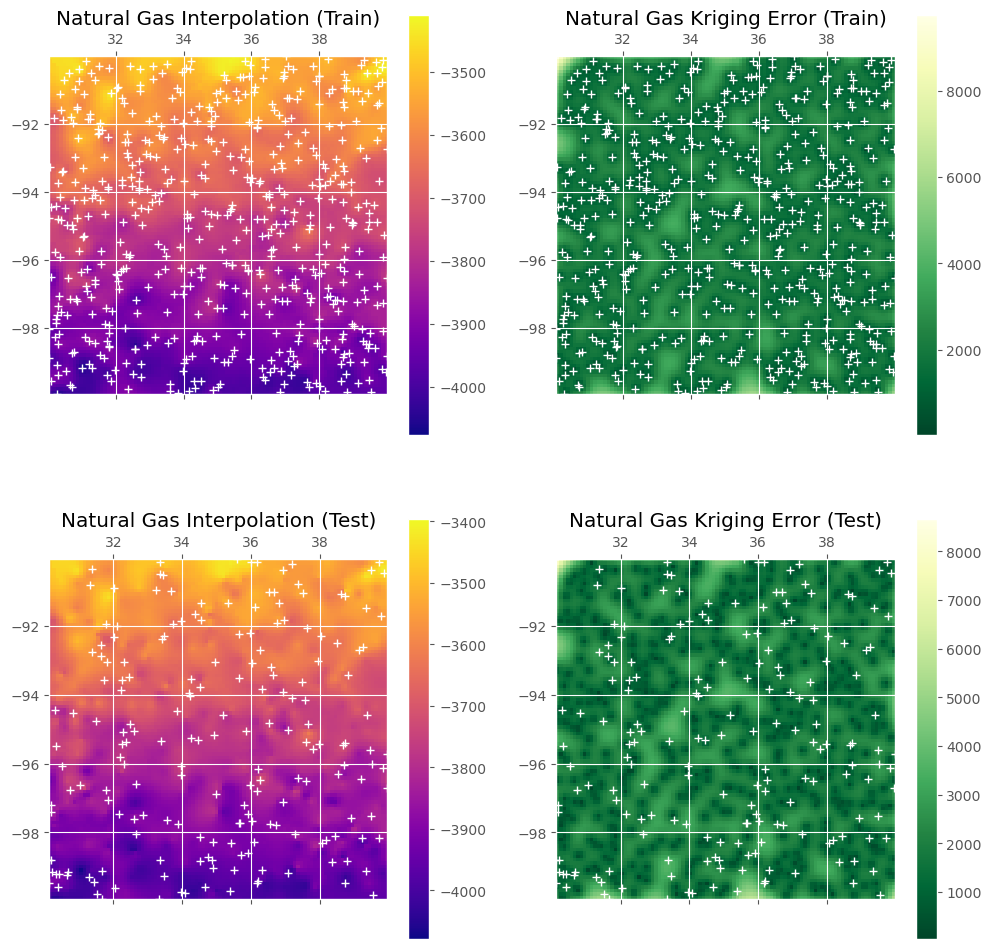

In [10]:
x_train = xy_gasprod_train[:,0]
y_train = xy_gasprod_train[:,1]
xx_train, yy_train = np.mgrid[x_train.min():x_train.max():100j, y_train.min():y_train.max():100j]
field_train = ok.transform(xx_train.flatten(), yy_train.flatten()).reshape(xx_train.shape)
s2_train = ok.sigma.reshape(xx_train.shape)

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12,12))

gas_interpolation_train = ax1.matshow(field_train.T, origin='lower', cmap='plasma', 
                                vmin=v_gasprod_train.min(), vmax=v_gasprod_train.max(), 
                                extent=[x_train.min(), x_train.max(), y_train.min(), y_train.max()])
ax1.plot(x_train, y_train, 'w+')
ax1.set_title('Natural Gas Interpolation (Train)')
ax1.set_xlim((x_train.min(), x_train.max()))
ax1.set_ylim((y_train.min(), y_train.max()))
plt.colorbar(gas_interpolation_train, ax=ax1)

gas_error_train = ax2.matshow(s2_train.T, origin='lower', cmap='YlGn_r', 
                        extent=[x_train.min(), x_train.max(), y_train.min(), y_train.max()])
ax2.plot(x_train, y_train, 'w+')
ax2.set_title('Natural Gas Kriging Error (Train)')
ax2.set_xlim((x_train.min(), x_train.max()))
ax2.set_ylim((y_train.min(), y_train.max()))
plt.colorbar(gas_error_train, ax=ax2)

x_test = xy_gasprod_test[:,0]
y_test = xy_gasprod_test[:,1]
xx_test, yy_test = np.mgrid[x_test.min():x_test.max():100j, y_test.min():y_test.max():100j]
field_test = ok.transform(xx_test.flatten(), yy_test.flatten()).reshape(xx_test.shape)
s2_test = ok.sigma.reshape(xx_test.shape)

gas_interpolation_test = ax3.matshow(field_test.T, origin='lower', cmap='plasma', 
                                vmin=v_gasprod_test.min(), vmax=v_gasprod_test.max(), 
                                extent=[x_test.min(), x_test.max(), y_test.min(), y_test.max()])
ax3.plot(x_test, y_test, 'w+')
ax3.set_title('Natural Gas Interpolation (Test)')
ax3.set_xlim((x_test.min(), x_test.max()))
ax3.set_ylim((y_test.min(), y_test.max()))
plt.colorbar(gas_interpolation_test, ax=ax3)

gas_error_test = ax4.matshow(s2_test.T, origin='lower', cmap='YlGn_r', 
                        extent=[x_test.min(), x_test.max(), y_test.min(), y_test.max()])
ax4.plot(x_test, y_test, 'w+')
ax4.set_title('Natural Gas Kriging Error (Test)')
ax4.set_xlim((x_test.min(), x_test.max()))
ax4.set_ylim((y_test.min(), y_test.max()))
plt.colorbar(gas_error_test, ax=ax4)

plt.show()
plt.close()

### Gas Production - Kriging - Hyperparameter Tuning

Tuning: ('spherical', 10, 3, 10)
CV_RMSE: 61.703556616346575
Tuning: ('spherical', 10, 3, 15)
CV_RMSE: 61.70355661634658
Tuning: ('spherical', 10, 6, 10)
CV_RMSE: 61.703556616346575
Tuning: ('spherical', 10, 6, 15)
CV_RMSE: 61.703556616346575
Tuning: ('spherical', 20, 3, 10)
CV_RMSE: 61.70355661634656
Tuning: ('spherical', 20, 3, 15)
CV_RMSE: 61.70355661634655
Tuning: ('spherical', 20, 6, 10)
CV_RMSE: 61.70355661634655
Tuning: ('spherical', 20, 6, 15)
CV_RMSE: 61.70355661634656
Tuning: ('exponential', 10, 3, 10)
CV_RMSE: 61.647400567815296
Tuning: ('exponential', 10, 3, 15)
CV_RMSE: 61.6474005678153
Tuning: ('exponential', 10, 6, 10)
CV_RMSE: 61.647400567815296
Tuning: ('exponential', 10, 6, 15)
CV_RMSE: 61.6474005678153
Tuning: ('exponential', 20, 3, 10)
CV_RMSE: 61.64740056781541
Tuning: ('exponential', 20, 3, 15)
CV_RMSE: 61.64740056781541
Tuning: ('exponential', 20, 6, 10)
CV_RMSE: 61.6474005678154
Tuning: ('exponential', 20, 6, 15)
CV_RMSE: 61.64740056781541
Tuning: ('gaussian', 1

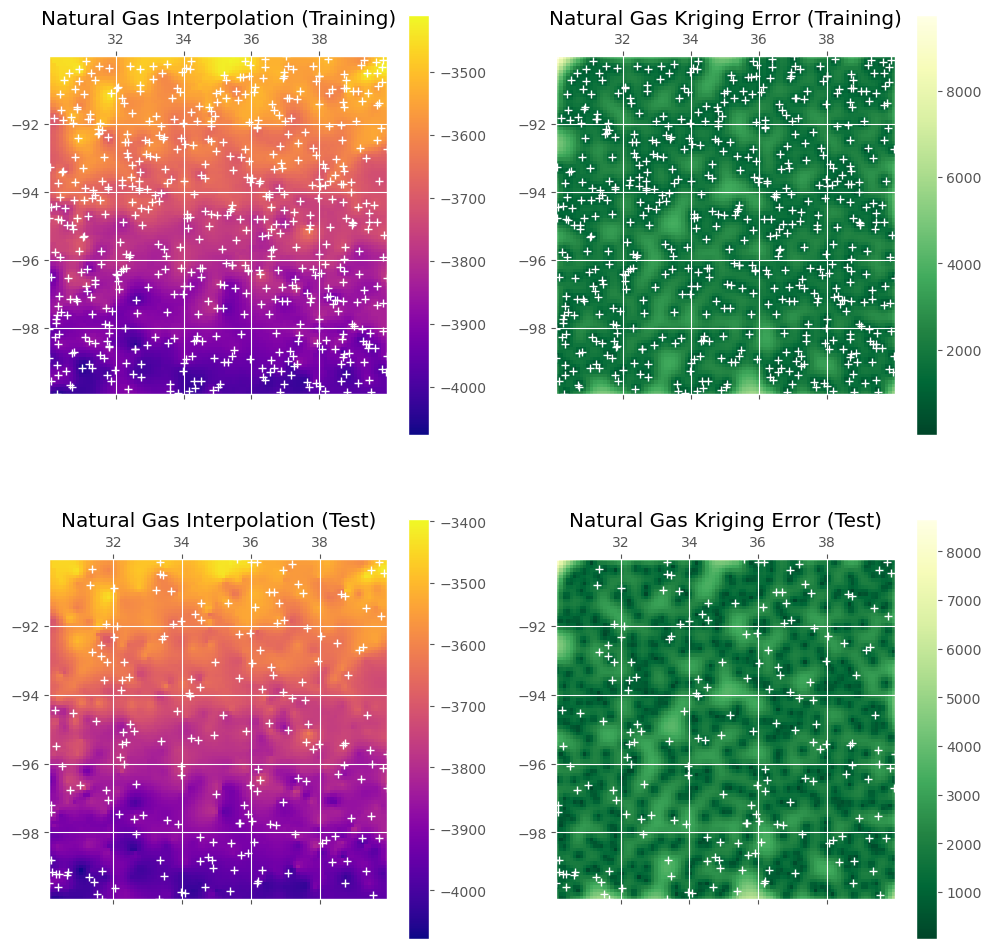

In [11]:
param_grid = {
    'model': ['spherical', 'exponential', 'gaussian'],
    'n_lags': [10, 20],
    'min_points': [3, 6],
    'max_points': [10, 15],
    'n_jobs': [-1] }

best_score = float('inf')
best_params = {}

for model, n_lags, min_pts, max_pts in product(
        param_grid['model'], param_grid['n_lags'],
        param_grid['min_points'], param_grid['max_points']):
    print(f'Tuning: {model, n_lags, min_pts, max_pts}')
    
    variogram = Variogram(
        coordinates=xy_gasprod_train,
        values=v_gasprod_train,
        model=model,
        n_lags=n_lags)
    
    cv_score = variogram.cross_validate(metric='rmse')
    print(f"CV_RMSE: {cv_score}")
    if cv_score < best_score:
        best_score = cv_score
        best_params = {
            'model': model,
            'n_lags': n_lags,
            'min_points': min_pts,
            'max_points': max_pts}

print("Best parameters:", best_params)
print("Best CV RMSE:", best_score)

best_variogram = Variogram(coordinates=xy_gasprod_train, values=v_gasprod_train, **best_params)
ok_tuned = OrdinaryKriging(
        best_variogram,
        min_points=best_params['min_points'],
        max_points=best_params['max_points'])

pred_tuned = ok.transform(xy_gasprod_test)
actual_tuned = v_gasprod_test
test['pred_GasProd'] = pred_tuned
s2_tuned = ok.sigma

print('\n------------')
print('Best Tuned Model:')
rmse = np.sqrt(mean_squared_error(actual_tuned, pred_tuned))
print("RMSE:", rmse)
mae = mean_absolute_error(actual_tuned, pred_tuned)
print("MAE:", mae)
r2 = r2_score(actual_tuned, pred_tuned)
print("R2:", r2)

print('\n------------')
print('Best Tuned Model Plots:\n')
x_train = xy_gasprod_train[:, 0]
y_train = xy_gasprod_train[:, 1]
xx_train, yy_train = np.mgrid[x_train.min():x_train.max():100j, y_train.min():y_train.max():100j]
field_train = ok.transform(xx_train.flatten(), yy_train.flatten()).reshape(xx_train.shape)
s2_train = ok.sigma.reshape(xx_train.shape)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

gas_interpolation_train = ax1.matshow(field_train.T, origin='lower', cmap='plasma',
                                      vmin=v_gasprod_train.min(), vmax=v_gasprod_train.max(),
                                      extent=[x_train.min(), x_train.max(), y_train.min(), y_train.max()])
ax1.plot(x_train, y_train, 'w+')
ax1.set_title('Natural Gas Interpolation (Training)')
ax1.set_xlim((x_train.min(), x_train.max()))
ax1.set_ylim((y_train.min(), y_train.max()))
plt.colorbar(gas_interpolation_train, ax=ax1)

gas_error_train = ax2.matshow(s2_train.T, origin='lower', cmap='YlGn_r',
                              extent=[x_train.min(), x_train.max(), y_train.min(), y_train.max()])
ax2.plot(x_train, y_train, 'w+')
ax2.set_title('Natural Gas Kriging Error (Training)')
ax2.set_xlim((x_train.min(), x_train.max()))
ax2.set_ylim((y_train.min(), y_train.max()))
plt.colorbar(gas_error_train, ax=ax2)

x_test = xy_gasprod_test[:, 0]
y_test = xy_gasprod_test[:, 1]
xx_test, yy_test = np.mgrid[x_test.min():x_test.max():100j, y_test.min():y_test.max():100j]
field_test = ok.transform(xx_test.flatten(), yy_test.flatten()).reshape(xx_test.shape)
s2_test = ok.sigma.reshape(xx_test.shape)

gas_interpolation_test = ax3.matshow(field_test.T, origin='lower', cmap='plasma',
                                     vmin=v_gasprod_test.min(), vmax=v_gasprod_test.max(), 
                                     extent=[x_test.min(), x_test.max(), y_test.min(), y_test.max()])
ax3.plot(x_test, y_test, 'w+')
ax3.set_title('Natural Gas Interpolation (Test)')
ax3.set_xlim((x_test.min(), x_test.max()))
ax3.set_ylim((y_test.min(), y_test.max()))
plt.colorbar(gas_interpolation_test, ax=ax3)

gas_error_test = ax4.matshow(s2_test.T, origin='lower', cmap='YlGn_r',
                             extent=[x_test.min(), x_test.max(), y_test.min(), y_test.max()])
ax4.plot(x_test, y_test, 'w+')
ax4.set_title('Natural Gas Kriging Error (Test)')
ax4.set_xlim((x_test.min(), x_test.max()))
ax4.set_ylim((y_test.min(), y_test.max()))
plt.colorbar(gas_error_test, ax=ax4)

plt.show()
plt.close()

## Spatially Uncorrelated Data

In [12]:
df = df_nocorr.copy()
print(df.shape)
df.head()

(750, 17)


,API_WellNo,Cnty,Well_Type,Well_Status,Producing_name,Producing_formation,Proposed_depth,Surface_Longitude,Surface_Latitude,Bottom_hole_longitude,Bottom_hole_latitude,True_vertical_depth,Measured_depth,GasProd,OilProd,WaterProd,Year
0,24012181361672,CountyC,Gas,Active,Field2,Formation2,4352,-96.75,39.17,-96.25,31.17,2417,3280,708.96,471.76,304,2005
1,89418511661948,CountyA,Gas,Active,Field3,Formation2,4478,-97.30,34.07,-90.49,39.40,2681,4749,880.73,678.97,27,2010
2,30087839072036,CountyA,Gas,Active,Field1,Formation1,4927,-98.09,31.43,-92.68,36.28,1113,3538,"1,371.30",653.23,287,2010
3,28316077141053,CountyA,Oil,Inactive,Field1,Formation2,4684,-93.05,37.15,-94.01,33.35,1927,2016,"1,113.93",637.84,354,2005
4,59875564545465,CountyB,Gas,Inactive,Field3,Formation1,3841,-97.81,32.93,-98.44,31.39,2016,1443,709.59,431.05,966,2010


### Flattened Overview Plot `(Lat, Long, Hue=GasProd)`

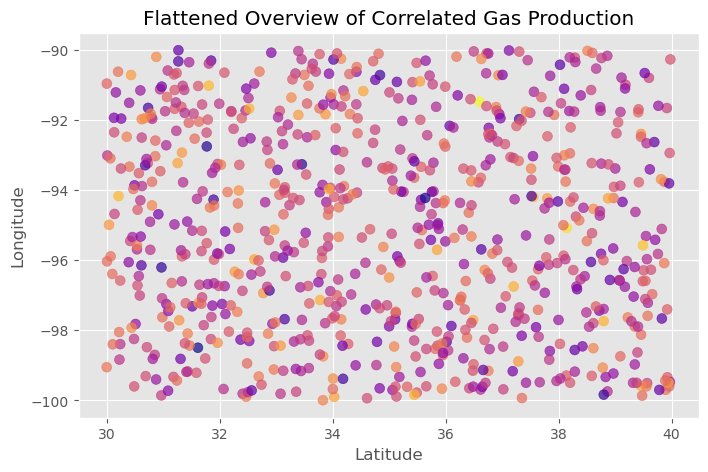

In [13]:
fig, ax = plt.subplots(1, figsize=(8,5))
nocorr_plot = ax.scatter(np.array(df['Surface_Latitude']), np.array(df['Surface_Longitude']), 
                       s=50, c=np.array(df['GasProd']).flatten(), cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Gas Production (Barrels)')
plt.title('Flattened Overview of Correlated Gas Production')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()
plt.close()

### Gas Production - Variogram

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 23.244698012628067,
 'normalized_sill': 11346240900.585281,
 'normalized_nugget': 0,
 'effective_range': 1.7462921164438172,
 'sill': 89140.38513482307,
 'nugget': 0,
 'params': {'estimator': 'matheron',
            'model': 'spherical',
            'dist_func': 'euclidean',
            'bin_func': 'even',
            'normalize': False,
            'fit_method': 'trf',
            'fit_sigma': None,
            'use_nugget': False,
            'maxlag': None,
            'n_lags': 10,
            'verbose': False},
 'kwargs': {}}


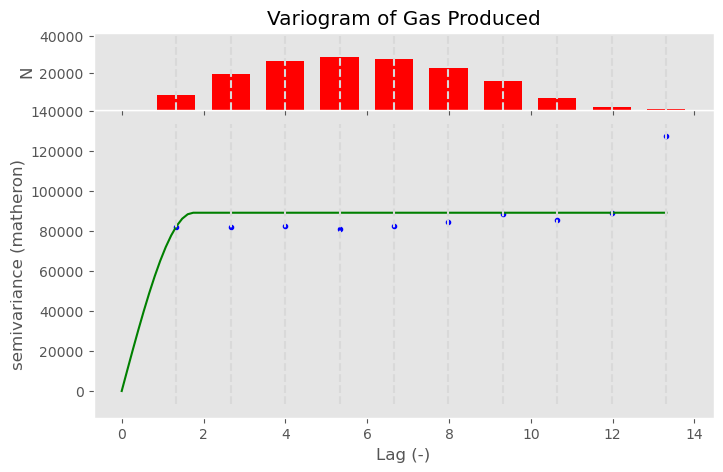

In [14]:
train, test = train_test_split(df, test_size=0.25, random_state=42)
xy_gasprod_train = np.array(train[['Surface_Latitude','Surface_Longitude']].values)
v_gasprod_train = np.array(train['GasProd'].values)

gas_variogram = Variogram(coordinates=xy_gasprod_train, values=v_gasprod_train)
pprint.pp(gas_variogram.describe())

gas_variogram.plot()
plt.title('Variogram of Gas Produced')
plt.show()
plt.close()

### Gas Production - Kriging

In [15]:
ok = OrdinaryKriging(gas_variogram)
xy_gasprod_test = np.array(test[['Surface_Latitude', 'Surface_Longitude']].values)
v_gasprod_test = np.array(test['GasProd'].values)

pred = ok.transform(xy_gasprod_test)
actual = v_gasprod_test
test['pred_GasProd'] = pred
s2 = ok.sigma

rmse = np.sqrt(mean_squared_error(actual, pred))
print("RMSE:", rmse)
mae = mean_absolute_error(actual, pred)
print("MAE:", mae)
r2 = r2_score(actual, pred)
print("R2:", r2)

RMSE: 371.96603873440966
MAE: 291.2169744772808
R2: -0.3718623896665445


### Gas Production - Kriging - Plot

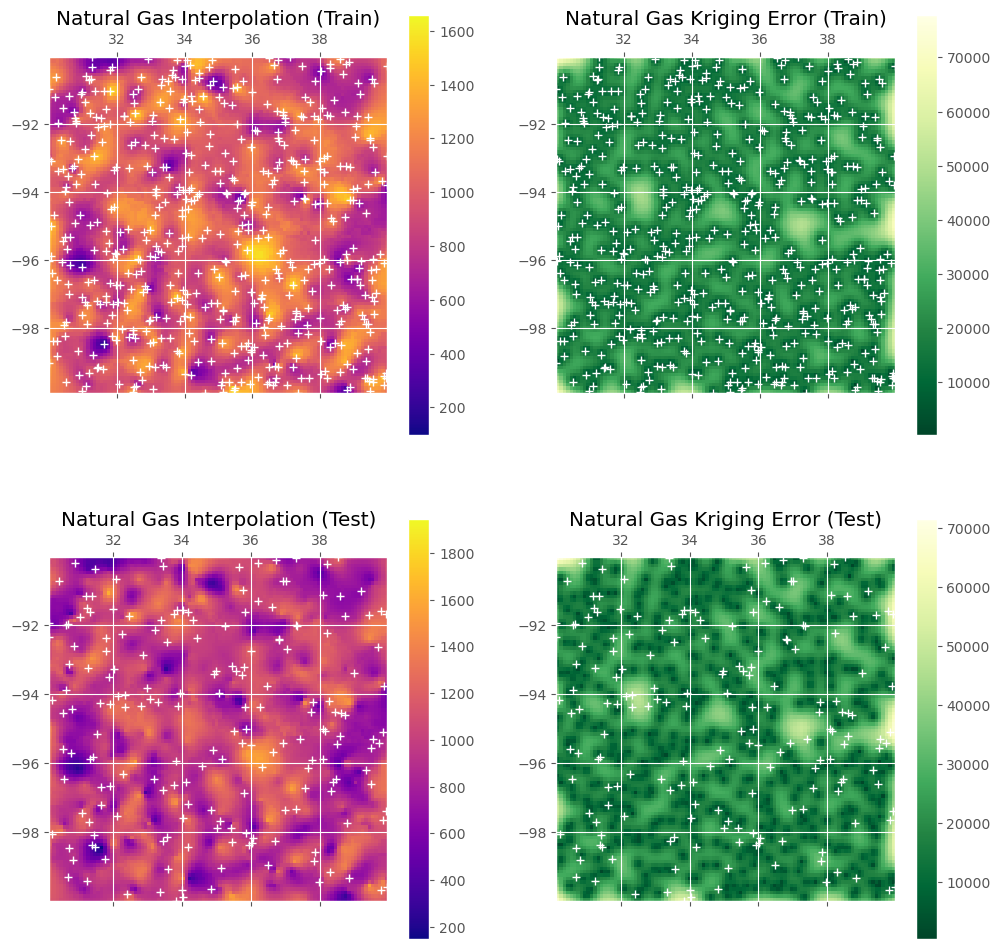

In [16]:
x_train = xy_gasprod_train[:,0]
y_train = xy_gasprod_train[:,1]
xx_train, yy_train = np.mgrid[x_train.min():x_train.max():100j, y_train.min():y_train.max():100j]
field_train = ok.transform(xx_train.flatten(), yy_train.flatten()).reshape(xx_train.shape)
s2_train = ok.sigma.reshape(xx_train.shape)

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12,12))

gas_interpolation_train = ax1.matshow(field_train.T, origin='lower', cmap='plasma', 
                                vmin=v_gasprod_train.min(), vmax=v_gasprod_train.max(), 
                                extent=[x_train.min(), x_train.max(), y_train.min(), y_train.max()])
ax1.plot(x_train, y_train, 'w+')
ax1.set_title('Natural Gas Interpolation (Train)')
ax1.set_xlim((x_train.min(), x_train.max()))
ax1.set_ylim((y_train.min(), y_train.max()))
plt.colorbar(gas_interpolation_train, ax=ax1)

gas_error_train = ax2.matshow(s2_train.T, origin='lower', cmap='YlGn_r', 
                        extent=[x_train.min(), x_train.max(), y_train.min(), y_train.max()])
ax2.plot(x_train, y_train, 'w+')
ax2.set_title('Natural Gas Kriging Error (Train)')
ax2.set_xlim((x_train.min(), x_train.max()))
ax2.set_ylim((y_train.min(), y_train.max()))
plt.colorbar(gas_error_train, ax=ax2)

x_test = xy_gasprod_test[:,0]
y_test = xy_gasprod_test[:,1]
xx_test, yy_test = np.mgrid[x_test.min():x_test.max():100j, y_test.min():y_test.max():100j]
field_test = ok.transform(xx_test.flatten(), yy_test.flatten()).reshape(xx_test.shape)
s2_test = ok.sigma.reshape(xx_test.shape)

gas_interpolation_test = ax3.matshow(field_test.T, origin='lower', cmap='plasma', 
                                vmin=v_gasprod_test.min(), vmax=v_gasprod_test.max(), 
                                extent=[x_test.min(), x_test.max(), y_test.min(), y_test.max()])
ax3.plot(x_test, y_test, 'w+')
ax3.set_title('Natural Gas Interpolation (Test)')
ax3.set_xlim((x_test.min(), x_test.max()))
ax3.set_ylim((y_test.min(), y_test.max()))
plt.colorbar(gas_interpolation_test, ax=ax3)

gas_error_test = ax4.matshow(s2_test.T, origin='lower', cmap='YlGn_r', 
                        extent=[x_test.min(), x_test.max(), y_test.min(), y_test.max()])
ax4.plot(x_test, y_test, 'w+')
ax4.set_title('Natural Gas Kriging Error (Test)')
ax4.set_xlim((x_test.min(), x_test.max()))
ax4.set_ylim((y_test.min(), y_test.max()))
plt.colorbar(gas_error_test, ax=ax4)

plt.show()
plt.close()

### Gas Production - Kriging - Hyperparameter Tuning

Tuning: ('spherical', 10, 3, 10)
CV_RMSE: 336.0482838974155
Tuning: ('spherical', 10, 3, 15)
CV_RMSE: 336.0482838974155
Tuning: ('spherical', 10, 6, 10)
CV_RMSE: 336.0482838974155
Tuning: ('spherical', 10, 6, 15)
CV_RMSE: 336.0482838974155
Tuning: ('spherical', 20, 3, 10)
CV_RMSE: 340.75737338265924
Tuning: ('spherical', 20, 3, 15)
CV_RMSE: 340.75737338265924
Tuning: ('spherical', 20, 6, 10)
CV_RMSE: 340.75737338265924
Tuning: ('spherical', 20, 6, 15)
CV_RMSE: 340.75737338265924
Tuning: ('exponential', 10, 3, 10)
CV_RMSE: 328.6610982907759
Tuning: ('exponential', 10, 3, 15)
CV_RMSE: 328.6610982907759
Tuning: ('exponential', 10, 6, 10)
CV_RMSE: 328.6610982907759
Tuning: ('exponential', 10, 6, 15)
CV_RMSE: 328.6610982907759
Tuning: ('exponential', 20, 3, 10)
CV_RMSE: 323.7457348394609
Tuning: ('exponential', 20, 3, 15)
CV_RMSE: 323.7457348394609
Tuning: ('exponential', 20, 6, 10)
CV_RMSE: 323.7457348394609
Tuning: ('exponential', 20, 6, 15)
CV_RMSE: 323.7457348394609
Tuning: ('gaussian',

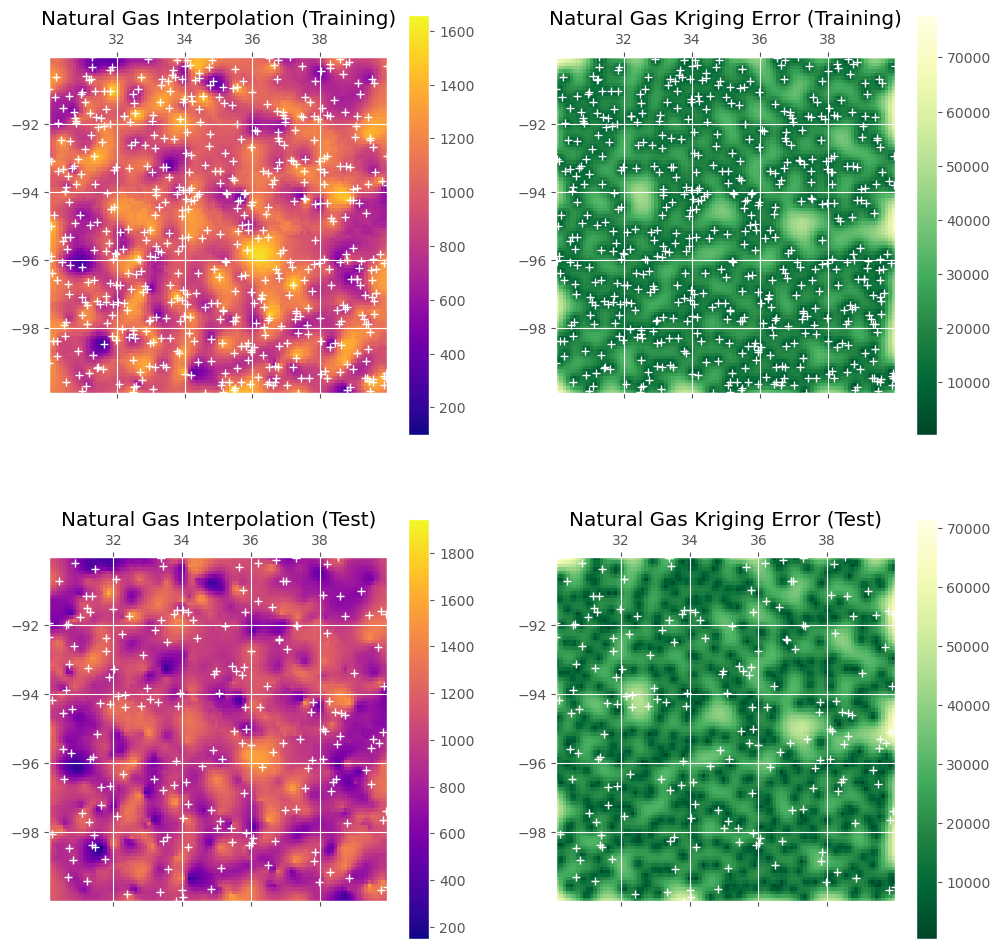

In [17]:
param_grid = {
    'model': ['spherical', 'exponential', 'gaussian'],
    'n_lags': [10, 20],
    'min_points': [3, 6],
    'max_points': [10, 15],
    'n_jobs': [-1] }

best_score = float('inf')
best_params = {}

for model, n_lags, min_pts, max_pts in product(
        param_grid['model'], param_grid['n_lags'],
        param_grid['min_points'], param_grid['max_points']):
    print(f'Tuning: {model, n_lags, min_pts, max_pts}')
    
    variogram = Variogram(
        coordinates=xy_gasprod_train,
        values=v_gasprod_train,
        model=model,
        n_lags=n_lags)
    
    cv_score = variogram.cross_validate(metric='rmse')
    print(f"CV_RMSE: {cv_score}")
    if cv_score < best_score:
        best_score = cv_score
        best_params = {
            'model': model,
            'n_lags': n_lags,
            'min_points': min_pts,
            'max_points': max_pts}

print("Best parameters:", best_params)
print("Best CV RMSE:", best_score)

best_variogram = Variogram(coordinates=xy_gasprod_train, values=v_gasprod_train, **best_params)
ok_tuned = OrdinaryKriging(
        best_variogram,
        min_points=best_params['min_points'],
        max_points=best_params['max_points'])

pred_tuned = ok.transform(xy_gasprod_test)
actual_tuned = v_gasprod_test
test['pred_GasProd'] = pred_tuned
s2_tuned = ok.sigma

print('\n------------')
print('Best Tuned Model:')
rmse = np.sqrt(mean_squared_error(actual_tuned, pred_tuned))
print("RMSE:", rmse)
mae = mean_absolute_error(actual_tuned, pred_tuned)
print("MAE:", mae)
r2 = r2_score(actual_tuned, pred_tuned)
print("R2:", r2)

print('\n------------')
print('Best Tuned Model Plots:\n')
x_train = xy_gasprod_train[:, 0]
y_train = xy_gasprod_train[:, 1]
xx_train, yy_train = np.mgrid[x_train.min():x_train.max():100j, y_train.min():y_train.max():100j]
field_train = ok.transform(xx_train.flatten(), yy_train.flatten()).reshape(xx_train.shape)
s2_train = ok.sigma.reshape(xx_train.shape)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

gas_interpolation_train = ax1.matshow(field_train.T, origin='lower', cmap='plasma',
                                      vmin=v_gasprod_train.min(), vmax=v_gasprod_train.max(),
                                      extent=[x_train.min(), x_train.max(), y_train.min(), y_train.max()])
ax1.plot(x_train, y_train, 'w+')
ax1.set_title('Natural Gas Interpolation (Training)')
ax1.set_xlim((x_train.min(), x_train.max()))
ax1.set_ylim((y_train.min(), y_train.max()))
plt.colorbar(gas_interpolation_train, ax=ax1)

gas_error_train = ax2.matshow(s2_train.T, origin='lower', cmap='YlGn_r',
                              extent=[x_train.min(), x_train.max(), y_train.min(), y_train.max()])
ax2.plot(x_train, y_train, 'w+')
ax2.set_title('Natural Gas Kriging Error (Training)')
ax2.set_xlim((x_train.min(), x_train.max()))
ax2.set_ylim((y_train.min(), y_train.max()))
plt.colorbar(gas_error_train, ax=ax2)

x_test = xy_gasprod_test[:, 0]
y_test = xy_gasprod_test[:, 1]
xx_test, yy_test = np.mgrid[x_test.min():x_test.max():100j, y_test.min():y_test.max():100j]
field_test = ok.transform(xx_test.flatten(), yy_test.flatten()).reshape(xx_test.shape)
s2_test = ok.sigma.reshape(xx_test.shape)

gas_interpolation_test = ax3.matshow(field_test.T, origin='lower', cmap='plasma',
                                     vmin=v_gasprod_test.min(), vmax=v_gasprod_test.max(), 
                                     extent=[x_test.min(), x_test.max(), y_test.min(), y_test.max()])
ax3.plot(x_test, y_test, 'w+')
ax3.set_title('Natural Gas Interpolation (Test)')
ax3.set_xlim((x_test.min(), x_test.max()))
ax3.set_ylim((y_test.min(), y_test.max()))
plt.colorbar(gas_interpolation_test, ax=ax3)

gas_error_test = ax4.matshow(s2_test.T, origin='lower', cmap='YlGn_r',
                             extent=[x_test.min(), x_test.max(), y_test.min(), y_test.max()])
ax4.plot(x_test, y_test, 'w+')
ax4.set_title('Natural Gas Kriging Error (Test)')
ax4.set_xlim((x_test.min(), x_test.max()))
ax4.set_ylim((y_test.min(), y_test.max()))
plt.colorbar(gas_error_test, ax=ax4)

plt.show()
plt.close()

## Script

In [18]:
df_corr.to_csv('toy_synth_corr_wells.csv', index=False)
df_nocorr.to_csv('toy_synth_nocorr_wells.csv', index=False)

In [19]:
try:
    print('Script executed successfully')
except:
    print('FAILED')

Script executed successfully
